In [1]:
#Import libraries

!pip install yfinance
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from datetime import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.


In [2]:
#Import timeframe

start = dt.date(2005,1,2)
end = dt.date(2020,4,30)
ticker = 'NFLX'

In [3]:
def download_daily_data(ticker, start, end):
  data = yf.download(ticker,start,end)

  return data

In [4]:
#Calculate Log Returns

def compute_daily_returns(data):
  data['cc_returns'] = np.log(data['Close'] / data['Close'].shift(1))

  return data

In [5]:
ticker2 = 'SPY'
end2 = dt.date(2020,7,2)
start2 = end2 - pd.Timedelta(days=365*15)

In [6]:
df = download_daily_data(ticker=ticker2, start=start2, end=end2)

[*********************100%***********************]  1 of 1 completed


In [7]:
df = compute_daily_returns(data=df)

In [8]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,cc_returns
Date,,,,,,,
2005-07-06,120.389999,120.650002,119.410004,119.480003,84.352020,52363600,NaN
2005-07-07,118.290001,119.949997,118.260002,119.949997,84.683868,103268800,0.003926
2005-07-08,119.970001,121.320000,119.720001,121.320000,85.651031,64491200,0.011357
2005-07-11,121.330002,122.099998,121.309998,121.940002,86.088783,49688300,0.005097
2005-07-12,121.989998,122.629997,121.639999,122.260002,86.314690,51871100,0.002621


In [9]:
#Strategy parameters

def compute_indicators(data):

  data['day'] = data.index.day_name()
  data['prev_day'] = data['day'].shift(1)
  data['four_days_after'] = data['day'].shift(-4)

  data['relative_range'] = (data['High'] - data['Low']) / data['Close']
  data['rel_range_ma'] = data['relative_range'].rolling(window=25).mean()

  data['ibs'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])

  return data

In [10]:
#Backtesting strategy

def backtest_strategy(data):

  data['condition1'] = np.where((data['day'] == 'Monday')
                        & (data['prev_day'] == 'Friday')
                        & (data['four_days_after'] == 'Friday'),
                        1,0)
  
  data['condition2'] = np.where((1-data['Close'] / data['Close'].shift(1))
                        >= 0.25 * data['rel_range_ma'],1,0)
  
  data['condition3'] = np.where(data['ibs'] < 0.3,1,0)

  data['signal'] = np.where((data['condition1']==1)
                    & (data['condition2']==1)
                    & (data['condition3']==1),
                    1,0)
  
  data['signal'] = data['signal'].shift(1)
  data['position'] = data['signal'].replace(to_replace=0, method='ffill', limit=3)
  data['strategy_returns'] = data['cc_returns'] * data['position']

  return data

In [11]:
def show_backtesting_results(data):
  print('buy and hold returns: ', np.round(data['cc_returns'].cumsum()[-1],2))
  print('strategy returns: ', np.round(data['strategy_returns'].cumsum()[-1]))

  data[['cc_returns','strategy_returns']] = data[['cc_returns','strategy_returns']].cumsum()
  data[['cc_returns','strategy_returns','position']].plot(
      secondary_y='position',grid=True,figsize=(12,8))

buy and hold returns:  0.96
strategy returns:  1.0


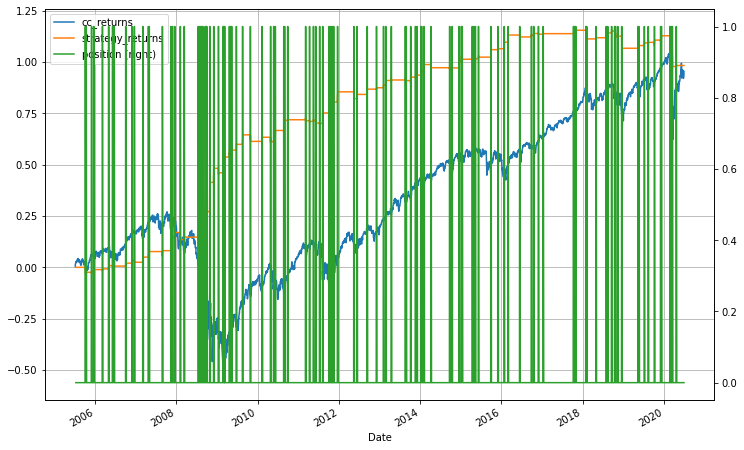

In [12]:
#Backtesting result

df = compute_indicators(df)
df = backtest_strategy(df)
show_backtesting_results(df)

<AxesSubplot:xlabel='Date'>

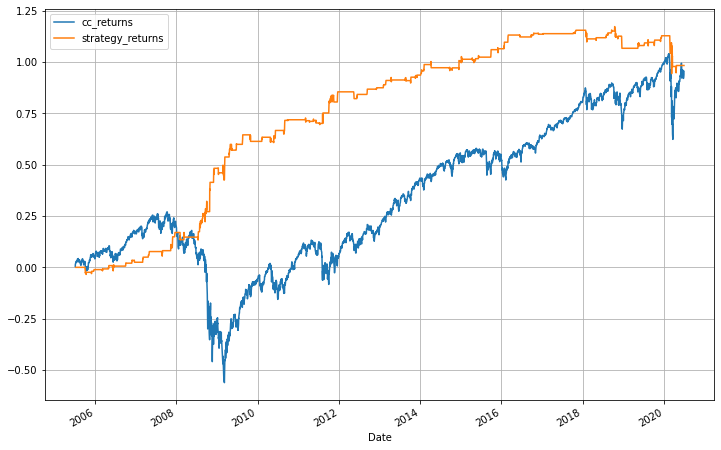

In [13]:
df[['cc_returns','strategy_returns']].plot(grid=True,figsize=(12,8))